In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

train = pd.read_csv('/home/ANANT/ajadhav/TweetTrolls/raw-tweets/train-tweets.csv',header=None)
dev = pd.read_csv('/home/ANANT/ajadhav/TweetTrolls/raw-tweets/dev-tweets.csv',header=None)
train = pd.concat([train,dev])

In [2]:
train.head()

,0,1,2,3
0,11,23,Ayarsız Retweet RT RT_America to #MAGA! https:...,RightTroll
1,12,23,VEGAS SURVIVOR ABRUPTLY DIES DAYS AFTER POSTIN...,RightTroll
2,13,118,Смотрите завтра в Камеди на ТНТ или на айфоне ...,Other
3,14,88,"#pjnet""#isis #islam 'Honor Killing' Un-Islamic...",RightTroll
4,15,53,Man killed in rollover on I-20 in southwest Da...,Other


[Text(0.5,0,'Class')]

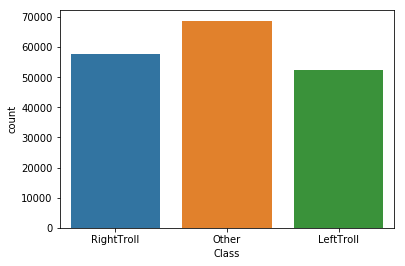

In [6]:
import seaborn as sns
ax = sns.countplot(train.iloc[:,3])
ax.set(xlabel='Class')

In [55]:
from sklearn.preprocessing import LabelEncoder
ClassEncoder = LabelEncoder()
train.iloc[:,3] = ClassEncoder.fit_transform(train.iloc[:,3])

In [56]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)', # anything else
    r'(?:http\S+)'
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 


In [57]:
clean_text = train.iloc[:,2].apply(preprocess)

In [58]:
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def URLremover(words):
    new_words = []
    for word in words:
        new_word = re.sub(r"http\S+", "", word)
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = URLremover(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words



In [59]:
train['cleanText'] = normalize(train.iloc[:,2])

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfModule = TfidfVectorizer(max_features  = 500)
tfidfModule.fit(train['cleanText'])
X = tfidfModule.transform(train['cleanText'])

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, train.iloc[:,3],test_size = 0.3)

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)

In [63]:
y_pred = model.predict(X_test)

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))

print('Accuracy of model is'  ,accuracy_score(y_test,y_pred)*100,'%')


[[10223  2149  3217]
 [ 2167 16460  2009]
 [ 4190  2046 11189]]
('Accuracy of model is', 70.59086672879776, '%')


In [65]:
test = pd.read_csv('/home/ANANT/ajadhav/TweetTrolls/raw-tweets/test-tweets.csv',header=None)
test['CleanText'] = normalize(test.iloc[:,2])
testX = tfidfModule.transform(test.iloc[:,4])
test.iloc[:,3] = model.predict(testX)                   
test.iloc[:,3] = ClassEncoder.inverse_transform(test.iloc[:,3])
test  = test.drop('CleanText',axis=1)

/home/ANANT/ajadhav/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
test.head()

,0,1,2,3
0,31,145,Don't underestimate the value of doing nothing...,LeftTroll
1,32,126,В Московском районе автомобиль Mazda врезался ...,Other
2,33,173,Canada: un adolescent plaide coupable de proje...,Other
3,34,173,"GOP Pol Grabs Woman By Genitals, Claims He Did...",RightTroll
4,35,84,They both like Fk this shit im out!! https://t...,LeftTroll


In [103]:
## Using existing TF IDF Vectors
# for Medium Matrix

TrainTF = pd.read_csv('/home/ANANT/ajadhav/TweetTrolls/medium-csv/train-best50.csv',header=None)
DevTf = pd.read_csv("/home/ANANT/ajadhav/TweetTrolls/medium-csv/dev-best50.csv",header=None)

TrainingTF = pd.concat([TrainTF,DevTf])
TrainingTfX = TrainingTF.iloc[:,2:]
TrainingTfY = TrainingTF.iloc[:,111]
TrainingTfY = ClassEncoder.transform(TrainingTfY)
TrainingTfX = TrainingTfX.drop(TrainingTfX.shape[1]+1,axis=1)
X_tra,X_te,y_tra,y_te = train_test_split(TrainingTfX, TrainingTfY,test_size = 0.3)
modelTF = rf.fit(X_tra,y_tra)
y_pr = modelTF.predict(X_te)
print(confusion_matrix(y_te,y_pr))
print('Accuracy of model using existing TFIDF vectors'  ,accuracy_score(y_te,y_pr)*100,'%')


[[ 8943  3221  3396]
 [ 1891 16879  1959]
 [ 4033  3444  9884]]
('Accuracy of model using existing TFIDF vectors', 66.55358807082945, '%')
